In [101]:
import numpy as np
import copy
import os
import re
import random
from PIL import Image
import cv2
import yaml
from matplotlib import pyplot as plt


In [3]:
def get_subdirectories(folder_path):
    subdirectories = []
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        if os.path.isdir(item_path):
            subdirectories.append(item)
    return subdirectories

def get_files_in_subdirectories(folder_path, file_extension='', file_contains=''):
    files = []
    for root, directories, filenames in os.walk(folder_path):
        for filename in filenames:
            if file_extension == '' and file_contains == '':
                files.append(os.path.join(root, filename))
            elif file_extension != '' and file_contains == '':
                if filename.endswith(file_extension):
                    files.append(os.path.join(root, filename))
            elif file_extension == '' and file_contains != '':
                if file_contains in filename:
                    files.append(os.path.join(root, filename))
            else:
                if file_contains in filename and filename.endswith(file_extension):
                    files.append(os.path.join(root, filename))
    return files


def extract_string(filename,format = 'stl'):
    pattern = r'\/([^/]+)\.'+format+'$'
    match = re.search(pattern, filename)
    if match:
        return match.group(1)
    else:
        return None
    
# Defining a function to convert degrees to radians.
def deg2rad(deg):
    return deg * np.pi/180

def get_rotated_pcd(pcd, x_theta, y_theta, z_theta):
    pcd_rotated = copy.deepcopy(pcd)
    R = pcd_rotated.get_rotation_matrix_from_axis_angle([x_theta, y_theta, z_theta])
    pcd_rotated.rotate(R, center=(0, 0, 0))
    return pcd_rotated

def create_folder_if_not_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Created folder: {folder_path}")
        return False
    else:
        print(f"Folder already exists: {folder_path}")
        return True

def delete_file(file_path):
    try:
        os.remove(file_path)
        # print(f"File '{file_path}' deleted successfully.")
    except FileNotFoundError:
        print(f"File '{file_path}' not found.")
    except PermissionError:
        print(f"Permission denied: unable to delete file '{file_path}'.")
    except Exception as e:
        print(f"An error occurred while deleting the file: {e}")

def create_binary_list(n, percentage_of_ones):
    if percentage_of_ones < 0 or percentage_of_ones > 100:
        raise ValueError("Percentage_of_ones must be between 0 and 100")

    num_ones = int(n * (percentage_of_ones / 100))
    num_zeros = n - num_ones

    binary_list = [1] * num_ones + [0] * num_zeros
    random.shuffle(binary_list)

    return binary_list


In [33]:
cwd = os.getcwd()
parent_dir = os.path.dirname(cwd)
data_path = parent_dir+'/data/'
cad_path = data_path + 'cad-models-threads/'
print(cad_path)
file_extension = '.stl'
path_save = data_path+'train_threads/imagesO/'
print(path_save)
files = get_files_in_subdirectories(cad_path,file_extension)

/Users/rodolfocacacho/Documents/Documents/MAI/Project module/3d_mai/data/cad-models-threads/
/Users/rodolfocacacho/Documents/Documents/MAI/Project module/3d_mai/data/train_threads/imagesO/


In [170]:
cwd = os.getcwd()
parent_dir = os.path.dirname(cwd)
data_path = parent_dir+'/data/'
cad_path = data_path + 'cad-models-threads/'
print(cad_path)
file_extension = '.stl'
path_imgs = data_path+'train_threads_b/imagesO/'
path_save = path_imgs.replace('imagesO','images')
path_val_save = path_save.replace('train','val')
labels_save = data_path+'train_threads_b/labels/'
labels_val_save = data_path+'val_threads_b/labels/'
path_save_bb = data_path+'train_threads_b/images_wbb/'
print(path_save)
files = get_files_in_subdirectories(cad_path,file_extension)
val_save = ''

exists_save = create_folder_if_not_exists(path_save)
if exists_save:
    images_del = get_files_in_subdirectories(path_save,'png')
    for imdel in images_del:
        delete_file(imdel)
exists_lb = create_folder_if_not_exists(labels_save)
if exists_lb:
    images_del = get_files_in_subdirectories(labels_save,'txt')
    for imdel in images_del:
        delete_file(imdel)
exists_wbb = create_folder_if_not_exists(path_save_bb)
if exists_wbb:
    images_del = get_files_in_subdirectories(path_save_bb,'png')
    for imdel in images_del:
        delete_file(imdel)

/Users/rodolfocacacho/Documents/Documents/MAI/Project module/3d_mai/data/cad-models-threads/
/Users/rodolfocacacho/Documents/Documents/MAI/Project module/3d_mai/data/train_threads_b/images/
Created folder: /Users/rodolfocacacho/Documents/Documents/MAI/Project module/3d_mai/data/train_threads_b/images/
Created folder: /Users/rodolfocacacho/Documents/Documents/MAI/Project module/3d_mai/data/train_threads_b/labels/
Created folder: /Users/rodolfocacacho/Documents/Documents/MAI/Project module/3d_mai/data/train_threads_b/images_wbb/


In [198]:
images_move = get_files_in_subdirectories(path_imgs,'.png')
unique_classes = []

for index, jpg in enumerate(images_move):
    filename = jpg.split('/')[-1].split('.')[0]
    classname = filename.split('_x')[0]

    # Load the image
    image = cv2.imread(jpg)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Perform edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the convex hull of the contours
    convex_hull = cv2.convexHull(np.vstack(contours))

    # Create a copy of the image for drawing the bounding box
    result_image = image.copy()

    # Calculate the bounding box of the convex hull
    x, y, w, h = cv2.boundingRect(convex_hull)

    aratio = w/h
    if aratio >= 1:
        px = 1
        py = int(1*aratio)
    else:
        px = int(1.0/aratio)
        py = 1
    x1 = x-px
    y1 = y-py
    x2 = x + w + px
    y2 = y + h + py
    w_reduce = 960
    h_reduce = 500
    # Calculate the maximum x and y coordinates for the new location
    max_x = image.shape[1] - w - int(w_reduce/2)
    max_y = image.shape[0] - h - int(h_reduce/2)

    # Generate random x and y coordinates for the new location
    new_x = np.random.randint(int(w_reduce/2), max_x + 1)
    new_y = np.random.randint(int(h_reduce/2), max_y + 1)
    if('asy' in classname):
        new_x = x1
        new_y = y1
    # Extract the object
    object_region = image[y1:y2, x1:x2].copy()

    # Paste the object into the new random location
    image[y1:y2, x1:x2] = [255, 255, 255]
    image[new_y-py:new_y+h+py, new_x-px:new_x+w+px] = object_region

    jpg_saving_path = jpg.replace("imagesO", "images")
    cv2.imwrite(jpg_saving_path, image)
    
    # Create a copy of the image for drawing the bounding box
    result_image = image.copy()

    # Draw the bounding box on the result image
    cv2.rectangle(result_image, (new_x, new_y), (new_x + w, new_y + h), (0, 255, 0), 2)
    bounding_box_saving_path = jpg.replace("imagesO", "images_wbb")
    cv2.imwrite(bounding_box_saving_path, result_image)

    center_x = new_x + (w) / 2
    center_y = new_y + (h) / 2
    relative_width = (w) / image.shape[1]
    #print(relative_width)
    relative_height = (h) / image.shape[0]
    #print(relative_height)
    relative_center_x= center_x / image.shape[1]
    relative_center_y= center_y / image.shape[0]

    # Open a file for writing the results
    
    if classname not in unique_classes:
        unique_classes.append(classname)
    encoded_class = unique_classes.index(classname)
    with open(labels_save + filename + '.txt', 'w') as file:
        file.write(f"{encoded_class} {relative_center_x:.5f} {relative_center_y:.5f} {relative_width:.5f} {relative_height:.5f}")    

In [112]:
unique_classes

['dst4', 'm4_10mm', 'din125_m4', 'm4_20mm', 'asy_m4_nut_screw_10mm']

### Zoom augmentation with labels

In [208]:

def convert_jpg_to_png(input_folder, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop through all files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".jpg"):
            # Open the JPG image
            jpg_path = os.path.join(input_folder, filename)
            img = Image.open(jpg_path)

            # Create the output PNG filename
            png_filename = os.path.splitext(filename)[0] + ".png"
            png_path = os.path.join(output_folder, png_filename)

            # Save the image in PNG format
            img.save(png_path, "PNG")
            os.remove(jpg_path)

            # print(f"Converted: {filename} -> {png_filename}")

def clean_name(input_folder,output_folder):

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        base_filename, file_extension = os.path.splitext(filename)
        name = base_filename.split("oom_")[0]+'oom'
        new_filename = name+file_extension
        old_path = os.path.join(input_folder, filename)
        new_path = os.path.join(output_folder, new_filename)
        os.rename(old_path, new_path)

def append_text_files(file1_path, file2_path):
    try:
        # Read the content of the second file
        with open(file2_path, 'r') as file2:
            content_to_append = '\n'+file2.read()

        # Append the content to the first file
        with open(file1_path, 'a') as file1:
            file1.write(content_to_append)

    except FileNotFoundError:
        print(f"File not found: {file2_path}")

def percentages_to_coordinates(bbox_percentages, image_width, image_height):
    rx, ry, rwo, rho = bbox_percentages

    ho = rho*image_height
    wo = rwo*image_width
    print(f'height o {ho} width {wo}')
    print(f'height i {image_height} width {image_width}')

    x_1 = int((rx*image_width-wo/2.0))
    y_1 = int((ry*image_height-ho/2.0))
    x_2 = int((x_1 + wo))
    y_2 = int((y_1 + ho))

    return x_1, y_1, x_2, y_2


def resize_and_place_object(image_path, original_bbox, scale_factor):

    # Crop the region inside the original bounding box
    x1, y1, x2, y2 = original_bbox
    ow = x2-x1
    oh = y2-y1
    print(f'{y1} {y2} {x1} {x2}')
    w_reduce = 960
    h_reduce = 500

    # Load the original image
    if scale_factor > 1 or scale_factor < 1:

        original_image = cv2.imread(image_path)
        object_region = original_image[y1:y2, x1:x2].copy()
        new_w = int(scale_factor*(ow))
        new_h = int(scale_factor*(oh))
        resized_object = cv2.resize(object_region, (new_w,new_h))

        print(f'h {new_h} w{new_w}')
        # Paste the object into the new random location
        original_image[y1:y2, x1:x2] = [255, 255, 255]


        # Calculate the maximum x and y coordinates for the new location
        max_x = original_image.shape[1] - new_w - int(w_reduce/2)
        max_y = original_image.shape[0] - new_h - int(h_reduce/2)

        # Generate random x and y coordinates for the new location
        new_x = np.random.randint(int(w_reduce/2), max_x + 1)
        new_y = np.random.randint(int(h_reduce/2), max_y + 1)
        original_image[new_y:new_y+new_h, new_x:new_x+new_w] = resized_object

        # cv2.rectangle(original_image, (x1, y1), (new_w + x1, new_h + y1), (0, 255, 0), 2)
    
    else:
        original_image = cv2.imread(image_path)

    return original_image


input_folder = "/Users/rodolfocacacho/Documents/Documents/MAI/Project module/3d_mai/data/train_threads_b/Assembly 3d/train/images/"
output_folder = "/Users/rodolfocacacho/Documents/Documents/MAI/Project module/3d_mai/data/train_threads_b/Assembly 3d/train/images2/"

# Labels
input_folder_l = "/Users/rodolfocacacho/Documents/Documents/MAI/Project module/3d_mai/data/train_threads_b/Assembly 3d/train/labels/"
output_folder_l = "/Users/rodolfocacacho/Documents/Documents/MAI/Project module/3d_mai/data/train_threads_b/Assembly 3d/train/labels2/"

# clean_name(input_folder, input_folder)
# convert_jpg_to_png(input_folder, input_folder)
# clean_name(input_folder_l, input_folder_l)


['dst4', 'm4_10mm']
/Users/rodolfocacacho/Documents/Documents/MAI/Project module/3d_mai/data/train_threads_b/images/asy_m4_nut_screw_10mm_x-4_y-3_z-4_z-z1oom.png
height o 165.024 width 200.064
height i 1080 width 1920
b box asy_m4_nut_screw_10mm : [0.50156, 0.49306, 0.10417, 0.15278] new b box (863, 450, 1063, 615)
move image
450 615 863 1063
h 113 w138


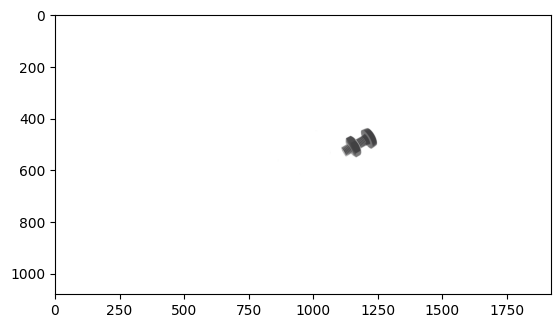

In [228]:
asy_images = [file.replace('imagesO','images') for file in images_move if 'asy' in file]
len(asy_images)

data_path_threads =  data_path+'train_threads_b/'
path_assembly = data_path_threads + 'Assembly 3d/'
path_config = path_assembly+'data.yaml'
path_labels = 'Assembly 3d/train/labels/'

# Load YAML file
with open(path_config, 'r') as file:
    data = yaml.safe_load(file)

# Extract names from the YAML data
names = data.get('names', [])
print(names)
zoom_range = [0.69,0.69,0.52]


for index_1,image in enumerate(asy_images):
    print(image)
    label_1 = image.replace('images','labels').replace('png','txt')  # Replace with the actual path to your first file
    label_2 = image.replace('images',path_labels).replace('png','txt')  # Replace with the actual path to your second file
    append_text_files(label_1, label_2)

    original_image = Image.open(image)
    w,h = original_image.size

    # Read the content of the file and split it into lines
    with open(label_1, 'r') as file:
        lines = file.read().splitlines()

    # Convert each line to a list of floats
    data_lists = [list(map(float, line.split())) for line in lines]

    # Example: Print the resulting lists
    for index_2,data_list in enumerate(data_lists):
        bbox_per = data_list[1:5]
        bbox_per = [round(element,4) for element in bbox_per]
        object = round(data_list[0])
        bbox = percentages_to_coordinates(bbox_per,w,h)
        print(f'b box {unique_classes[int(object)]} : {data_list[1:5]} new b box {bbox}')
        if(index_2 == 0):
            print('move image')
            for index_3,zoom in enumerate(zoom_range):
                result_image = resize_and_place_object(image, bbox, zoom)
                break
                # Draw the bounding box on the result image
            pz = '/Users/rodolfocacacho/Documents/Documents/MAI/Project module/3d_mai/data/train_threads_b/zoom1.png'
            cv2.imwrite(pz, result_image)
        break
    break
        
plt.imshow(result_image)







h 160 w 160


['dst4', 'm4_10mm', 'din125_m4', 'm4_20mm', 'asy_m4_nut_screw_10mm'] ['dst4', 'm4_10mm']


In [ ]:

# Example usage
original_bbox = [50, 30, 200, 150]
scale_factor = 0.8  # 80% reduction
output_width = 800
output_height = 600
# image_path = "path/to/your/image.jpg"  # Replace with the actual path to your image

# result_image = resize_and_place_object(image_path, original_bbox, scale_factor, output_width, output_height)
# result_image.show()


### Move images into train and test folder

In [ ]:
test_list = create_binary_list(len(images_move), 20)


 # Save the edited image
    if test_list[index] == 0:
        jpg_saving_path = jpg.replace("imagesO", "images")
        cv2.imwrite(jpg_saving_path, image)
    else:
        jpg_saving_path = jpg.replace("imagesO", "images")
        jpg_saving_path = jpg_saving_path.replace("train", "val")
        # print(jpg_saving_path)
        cv2.imwrite(jpg_saving_path, image)
    
    # Create a copy of the image for drawing the bounding box
    result_image = image.copy()

    # Draw the bounding box on the result image
    cv2.rectangle(result_image, (new_x, new_y), (new_x + w, new_y + h), (0, 255, 0), 2)
    bounding_box_saving_path = jpg.replace("imagesO", "images_wbb")
    cv2.imwrite(bounding_box_saving_path, result_image)

    center_x = new_x + (w) / 2
    center_y = new_y + (h) / 2
    relative_width = (w) / image.shape[1]
    #print(relative_width)
    relative_height = (h) / image.shape[0]
    #print(relative_height)
    relative_center_x= center_x / image.shape[1]
    relative_center_y= center_y / image.shape[0]

    # Open a file for writing the results
    filename = jpg.split('/')[-1].split('.')[0]
    classname = filename.split('_x')[0]
    if classname not in unique_classes:
        unique_classes.append(classname)
    encoded_class = unique_classes.index(classname)
    if test_list[index] == 0:
        with open(labels_save + filename + '.txt', 'w') as file:
            file.write(f"{encoded_class} {relative_center_x:.5f} {relative_center_y:.5f} {relative_width:.5f} {relative_height:.5f}")
    else:
        with open(labels_save.replace('train','val') + filename + '.txt', 'w') as file:
            file.write(f"{encoded_class} {relative_center_x:.5f} {relative_center_y:.5f} {relative_width:.5f} {relative_height:.5f}")

In [25]:


print(names)


['nut', 'screw']
